In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import AutoImageProcessor, AutoModelForImageClassification
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt

2025-04-18 07:58:43.119113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744963123.364281      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744963123.439752      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Paths
train_dir = "/kaggle/input/covid-1911/ash/train"
test_dir = "/kaggle/input/covid-1911/ash/test"

Using device: cuda


In [3]:
processor = AutoImageProcessor.from_pretrained("google/efficientnet-b4")
normalize = transforms.Normalize(mean=processor.image_mean, std=processor.image_std)

# Augmentations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((460, 460)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    transforms.Resize((460, 460)),
    transforms.ToTensor(),
    normalize
])

preprocessor_config.json:   0%|          | 0.00/495 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
# Datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Model
model = AutoModelForImageClassification.from_pretrained(
    "google/efficientnet-b4",
    num_labels=2,
    ignore_mismatched_sizes=True
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

config.json:   0%|          | 0.00/70.2k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/78.1M [00:00<?, ?B/s]

Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b4 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1792]) in the checkpoint and torch.Size([2, 1792]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Early Stopping
early_stop_patience = 5
no_improve_epochs = 0
best_val_accuracy = 0.0
save_path = "Covid_model_best.pth"
num_epochs = 15

In [7]:
# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss, running_correct = 0.0, 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = torch.argmax(outputs, dim=1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=running_loss/total, acc=100*running_correct/total)

    train_loss = running_loss / total
    train_acc = 100 * running_correct / total

Epoch 1/15:   1%|          | 1/124 [00:02<04:34,  2.23s/it, acc=68.8, loss=0.675]

model.safetensors:   0%|          | 0.00/78.0M [00:00<?, ?B/s]

Epoch 15/15: 100%|██████████| 124/124 [01:41<00:00,  1.22it/s, acc=95.4, loss=0.121]


In [27]:
best_val_accuracy = 0.0
no_improve_epochs = 0

for epoch in range(num_epochs):  # <-- Make sure this loop is present
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_loss /= train_total
    train_acc = 100 * train_correct / train_total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)

            val_loss += loss.item() * labels.size(0)
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = 100 * val_correct / val_total

    # Log results
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"📌 Epoch {epoch+1}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    # Step LR scheduler
    scheduler.step(val_loss)

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"✅ Saved new best model (Val Acc: {val_acc:.2f}%)")
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= early_stop_patience:
            print("⏹️ Early stopping triggered.")
            break  # ✅ Valid inside the loop

# Load best model after loop ends
model.load_state_dict(torch.load(save_path))
model.eval()


📌 Epoch 1: Train Acc: 95.56%, Val Acc: 97.99%
✅ Saved new best model (Val Acc: 97.99%)
📌 Epoch 2: Train Acc: 96.07%, Val Acc: 97.38%
📌 Epoch 3: Train Acc: 96.52%, Val Acc: 97.99%
📌 Epoch 4: Train Acc: 96.07%, Val Acc: 97.99%
📌 Epoch 5: Train Acc: 97.13%, Val Acc: 97.59%
📌 Epoch 6: Train Acc: 96.98%, Val Acc: 98.19%
✅ Saved new best model (Val Acc: 98.19%)
📌 Epoch 7: Train Acc: 97.28%, Val Acc: 97.59%
📌 Epoch 8: Train Acc: 97.68%, Val Acc: 97.18%
📌 Epoch 9: Train Acc: 97.63%, Val Acc: 98.39%
✅ Saved new best model (Val Acc: 98.39%)
📌 Epoch 10: Train Acc: 97.78%, Val Acc: 97.59%
📌 Epoch 11: Train Acc: 97.68%, Val Acc: 98.19%
📌 Epoch 12: Train Acc: 97.28%, Val Acc: 98.79%
✅ Saved new best model (Val Acc: 98.79%)
📌 Epoch 13: Train Acc: 97.73%, Val Acc: 99.20%
✅ Saved new best model (Val Acc: 99.20%)
📌 Epoch 14: Train Acc: 97.93%, Val Acc: 98.59%
📌 Epoch 15: Train Acc: 97.73%, Val Acc: 97.99%


/tmp/ipykernel_31/358394110.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


EfficientNetForImageClassification(
  (efficientnet): EfficientNetModel(
    (embeddings): EfficientNetEmbeddings(
      (padding): ZeroPad2d((0, 1, 0, 1))
      (convolution): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=valid, bias=False)
      (batchnorm): BatchNorm2d(48, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (encoder): EfficientNetEncoder(
      (blocks): ModuleList(
        (0): EfficientNetBlock(
          (depthwise_conv): EfficientNetDepthwiseLayer(
            (depthwise_conv_pad): ZeroPad2d((0, 1, 0, 1))
            (depthwise_conv): EfficientNetDepthwiseConv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=48, bias=False)
            (depthwise_norm): BatchNorm2d(48, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
            (depthwise_act): SiLU()
          )
          (squeeze_excite): EfficientNetSqueezeExciteLayer(
            (squeeze): AdaptiveAvgPool2d(output


✅ Final Test Accuracy: 99.20%

📋 Classification Report:
              precision    recall  f1-score   support

       COVID       0.98      1.00      0.99       251
   non-COVID       1.00      0.98      0.99       246

    accuracy                           0.99       497
   macro avg       0.99      0.99      0.99       497
weighted avg       0.99      0.99      0.99       497



<Figure size 800x600 with 0 Axes>

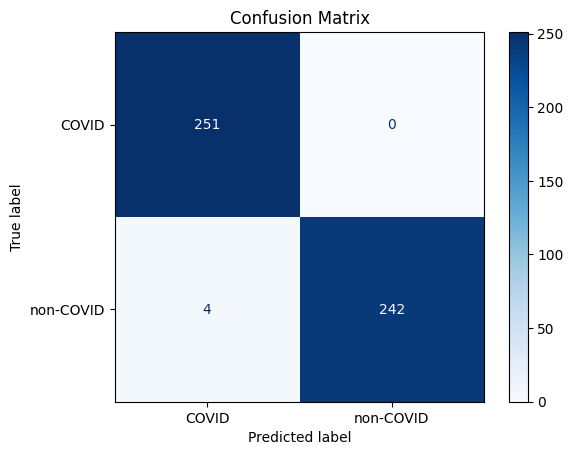

In [28]:
# Final evaluation
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
test_acc = accuracy_score(all_labels, all_preds) * 100
print(f"\n✅ Final Test Accuracy: {test_acc:.2f}%")
print("\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes, digits=2))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

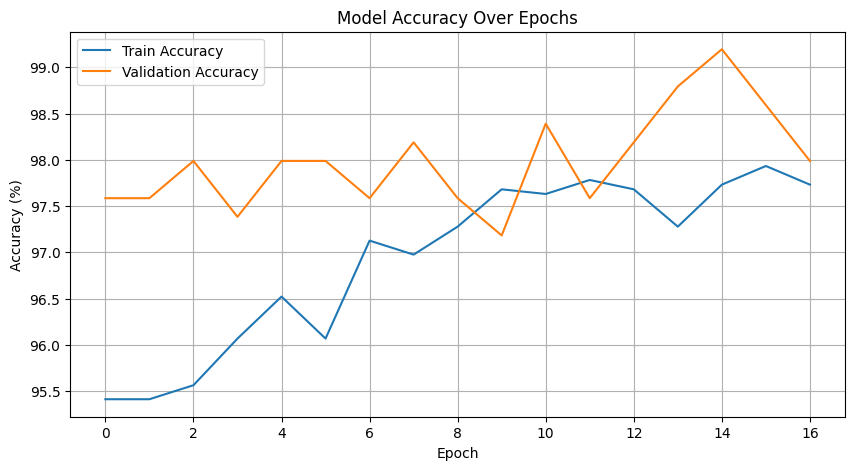

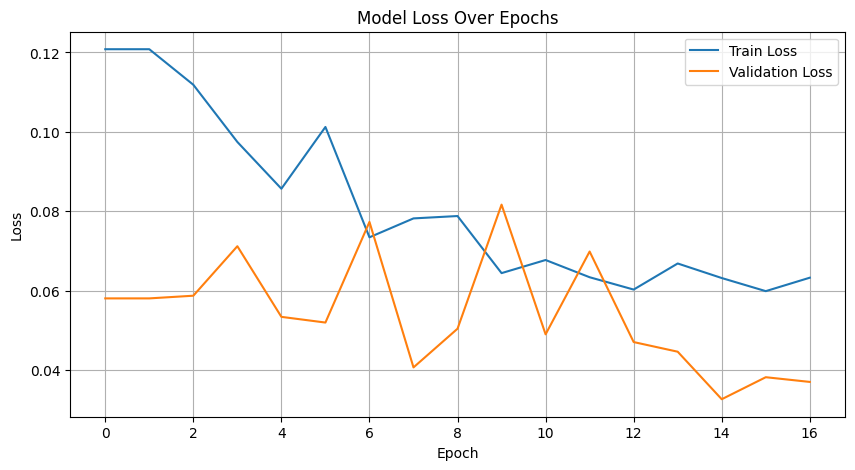

In [29]:
# Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b4 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1792]) in the checkpoint and torch.Size([2, 1792]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔍 Top Predictions:
  🔸 COVID: 99.94%
  🔸 NON-COVID: 0.06%

✅ Final Prediction: COVID (99.94%)
✅ Grad-CAM Layer: encoder.top_conv


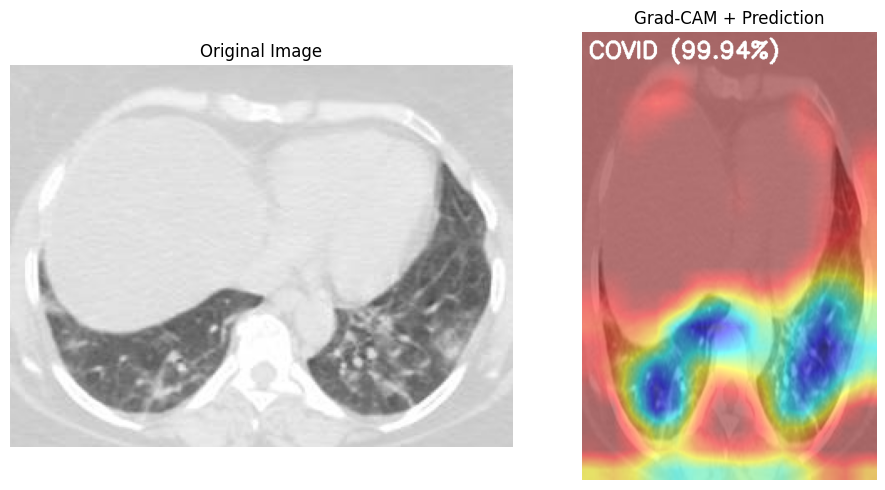

In [4]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from transformers import AutoImageProcessor, AutoModelForImageClassification

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load processor and model
processor = AutoImageProcessor.from_pretrained("google/efficientnet-b4")
model = AutoModelForImageClassification.from_pretrained(
    "google/efficientnet-b4",
    num_labels=2,
    ignore_mismatched_sizes=True
).to(device)

# Load trained weights
model_path = "C:\\Users\\ujwal\\Downloads\\web\\models\\Covid_model_best.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Image transform
transform = transforms.Compose([
    transforms.Resize((700, 460)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

# Grad-CAM helper
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(input_tensor).logits
        class_score = output[:, class_idx]
        class_score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.nn.functional.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# Prediction + GradCAM visualization
def predict_with_gradcam(image_path, class_names):
    original_img = Image.open(image_path).convert("RGB")
    input_tensor = transform(original_img).unsqueeze(0).to(device)

    outputs = model(input_tensor).logits
    probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Top-2 predictions
    topk = torch.topk(probabilities, k=2)
    print("\n🔍 Top Predictions:")
    for i in range(2):
        idx = topk.indices[0][i].item()
        prob = topk.values[0][i].item()
        print(f"  🔸 {class_names[idx]}: {prob * 100:.2f}%")

    predicted_class = torch.argmax(outputs, dim=1).item()
    confidence = probabilities[0][predicted_class].item() * 100
    print(f"\n✅ Final Prediction: {class_names[predicted_class]} ({confidence:.2f}%)")

    # Grad-CAM target layer (last conv layer of base_model)
    for name, module in reversed(list(model.base_model.named_modules())):
        if isinstance(module, torch.nn.Conv2d):
            target_layer = module
            print(f"✅ Grad-CAM Layer: {name}")
            break

    gradcam = GradCAM(model, target_layer)
    cam = gradcam.generate(input_tensor, predicted_class)

    # Superimpose heatmap
    img = np.array(original_img.resize((input_tensor.shape[3], input_tensor.shape[2])))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    superimposed_img = heatmap + np.float32(img) / 255
    superimposed_img = superimposed_img / np.max(superimposed_img)

    # Overlay prediction text
    display_img = (superimposed_img * 255).astype(np.uint8)
    label_text = f"{class_names[predicted_class]} ({confidence:.2f}%)"
    display_img = cv2.putText(display_img, label_text, (10, 40), cv2.FONT_HERSHEY_SIMPLEX,
                              1.2, (255, 255, 255), 3)

    # Display
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM + Prediction")
    plt.imshow(display_img)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Run it
class_names = ["COVID", "NON-COVID"]
image_path = "C:\\Users\\ujwal\\Downloads\\ash\\test\\COVID\\Covid (531).png"
predict_with_gradcam(image_path, class_names)